# Exercise 2(b): More Linear Algebra

Let's practice more using numpy and refreshing some linear algebra along the way.

## Problem 5

**Given**:
Two symmetric matrices ${\bf A}$ and ${\bf B}$, bot symmetric, are used to construct a series of matrices
$$
   {\bf K}(\lambda) := {\bf A} + \lambda {\bf B}
$$

A critical state occurs if ${\bf K}(\lambda)$ becomes singular.

In [1]:
# loading useful types and functions
from numpy import array
from numpy.linalg import eig, det

# define matrices A and B
A = array([
    [2,2,1,0,0],
    [2,4,2,1,0],
    [1,2,8,2,1],
    [0,1,2,4,2],
    [0,0,1,2,2]
])

B = array([
    [-1,-1, 1, 0, 0],
    [-1,-2,-1, 1, 0],
    [ 1,-1,-2,-1, 1],
    [ 0, 1,-1,-2,-1],
    [ 0, 0, 1,-1,-1]
])

# define a function to compute K
def K(s):
    return A + s*B


**Find (i)**: 
Use simple plotting locate critical values for $\lambda$.

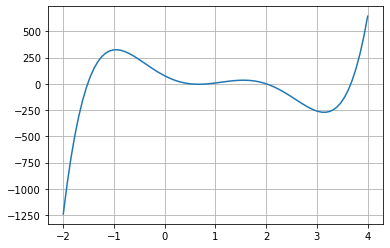

In [2]:
from numpy import linspace, zeros_like
import matplotlib.pyplot as plt

# setting the horizontal axis values ...
s = linspace(-2,4,80)

# YOUR CODE HERE ...
plt.plot(s,[det(K(x)) for x in s])
plt.grid(True)
plt.show()

**Find (ii)**: 
Discuss a strategy that would find critical states in an automated way. 
Suitable algorithms are _bisection_, _linear interpolation_, or the _Newton algorithm_. 

1. Write a function that takes one (or two) guesses for solutions and returns an improved guess.
2. Write another function that uses the first one to iteratively find a solution for which $\det {\bf K}<10^{-10}$ 

In [3]:
import copy
def my_fun(med):
    return det(K(med))
    
    
def biseccion(f,a,b,maxiter):
    tol=10e-10
    for i in range(maxiter):
        med=(a+b)/2
        if abs(f(med)) <tol:
            return med
        elif f(a)*f(med) <0:
            b=med*1.0
        elif f(b)*f(med) <0:
            a=med*1.0
    return None

print(biseccion(my_fun,-2,1.0,100))

-1.5205682013993282


**An analytical solution to the problem**:
Using Cholesky decomposition,
$$
{\bf A} = {\bf L}{\bf L}^t
$$
we find
$$
   {\bf A} + \lambda {\bf B}
   = 
   \lambda {\bf L}(\bar{\bf B}-\omega {\bf 1} ){\bf L}^t
   \qquad\text{with}\quad
   \omega = -\frac{1}{\lambda}
   \quad\text{and}\quad
   \bar{\bf B} = {\bf L}^{-1}{\bf B}{\bf L}^{-t}
$$
and, thus, the solution to the original question follows from the standard eigenvalue problem as
$$
   \bar{\bf B}-\omega {\bf 1} = {\bf 0}
   \qquad\Rightarrow\quad
   \lambda = -\frac{1}{\omega}
$$

In [4]:
from numpy.linalg import cholesky

L = cholesky(A)

In [5]:
from numpy.linalg import inv, eigvals

Linv = inv(L)
BB = Linv @ B @ Linv.T

om = eigvals(BB)
lam = -1./om

In [6]:
# output your results

for l in sorted(lam):
    print(l)

-1.5205682013989816
0.5000000000000002
0.8513653817620834
2.0000000000000004
3.6692028196368995


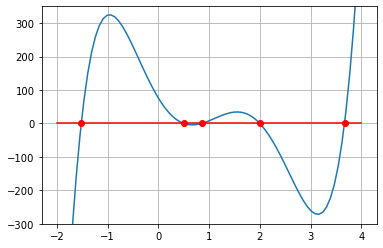

In [7]:
from numpy import linspace, zeros_like
import matplotlib.pyplot as plt

s = linspace(-2,4,80)
dK = [ det(K(x)) for x in s ]

plt.plot(s,dK)
plt.plot(s,zeros_like(s),'-r')
plt.plot(lam,zeros_like(lam),'or')
plt.grid(True)
plt.ylim(-300,350)
plt.show()

## Problem 6: coding a truss element

The stiffness method (CESG 501/CESG 506/CESG 506) defines the reaction force as
$$
   {\bf P}_e = f \,{\bf n}
$$
and the stiffness matrix for a truss element as
$$
   {\bf K}_e = \frac{EA}{\ell} \,{\bf n}\otimes{\bf n} + \frac{f}{\ell} \,({\bf 1}-{\bf n}\otimes{\bf n})
$$
where
    
| variable              | symbol        | definition            |
|:--------              |:--------      |:-----------           |
| **given**:            |               |                       |
| modulus of elasticity |   $E$	        |  `float`              |
| cross section area    |   $A$	        |  `float`              |       
| location vector for $i^{th}$ node ($i=1,2$) | ${\bf X}_i$	| `numpy.array` | 
| nodal displacement vector for $i^{th}$ node ($i=1,2$) | ${\bf u}_i$ | `numpy.array` |
| **computed**:         |               |                       | 
| original axial vector | $ {\bf L}_0 $ | $ {\bf X}_2 - {\bf X}_1 $ |
| deformed axial vector | $ {\bf L} $   | $ {\bf X}_2 + {\bf u}_2 - {\bf X}_1 - {\bf u}_1 $ |
| original length       | $\ell_0$      | $\| {\bf L}_0 \|$ |
| deformed length       | $\ell$        | $\| {\bf L} \|$ |
| normal vector         | ${\bf n}$     | $ { \frac{1}{\ell} ( {\bf L} ) } $ | 
| axial strain          | $\varepsilon$ |     $ \frac{1}{2} \left(\left(\frac{\ell}{\ell_0}\right)^2 - 1 \right) $ |    
| axial force           | $f$           | $ EA\, \varepsilon $  |
| **pre-defined**:      |               |                       |
| identity matrix       | $ {\bf 1} $   | `numpy.ones((3,3))`   |
| outer product         | $ \otimes $   | `numpy.outer(v,w)`    |
| **Return values**:    |               |                       |
| reaction force        | $ {\bf P}_e $ |  `numpy.array` (3-comp. vector) |
| nodal stiffness       | $ {\bf K}_e $ |  `numpy.array` (3x3 matrix)     |

**Your task**:
Complete a function `TrussElement(...)` that takes the provided input, computes ${\bf P}_e$ and ${\bf K}_e$, and returns both.

In [8]:
from numpy.linalg import norm
import numpy as np

def TrussElement(E,A,X1,X2,U1,U2):
    
    Lvec0 = X2 - X1
    ell0 = norm(Lvec0)
    
    Lvec = X2 + U2 - X1 - U1
    ell = norm(Lvec)
    nvec = Lvec/ell
    
    eps = (ell - ell0)/ell0
    f = E*A*eps
    Pe = f*nvec
    
    n_tensor_n = np.outer(nvec,nvec)
    Ke = E*A/ell * n_tensor_n + f/ell * (np.eye(3,3) - n_tensor_n )
    
    return (Pe, Ke)

I implemented a simple test procedure that
1. calls your function with two different data sets
2. compares your results against mine
3. prints info on whether or not your code produced the correct answers

**Your task**:
Simply define your function above and execute first your definition (above) and second my test procedure (below).

In [9]:
# TEST PROCEDURE
def tensorCompare(s,v,w):
    if np.linalg.norm(v-w)<1.e-8:
        print("*** {} SUCCESS - RESULTS MATCH ***".format(s))
    else:
        print("*** {} ERROR - NO MATCH ***".format(s))
        print("yours:\n",v,"\ntarget:\n",w,"---")

X1 = np.array([0.,0.,0.])
X2 = np.array([10.,5.,15.])

U1 = np.array([0.,0.,0.])
U2 = np.array([0.,0.,0.])

(P,K) = TrussElement(1000., 2.5, X1, X2, U1, U2)

tensorCompare("Pe #1",P,np.array([0., 0., 0.]))
tensorCompare("Ke #1",K,np.array([[38.18017742, 19.09008871, 57.27026612],
                                  [19.09008871,  9.54504435, 28.63513306],
                                  [57.27026612, 28.63513306, 85.90539919]]))

U1 = np.array([0.15,0.10,0.20])
U2 = np.array([0.05,0.25,0.10])

(P,K) = TrussElement(1000., 2.5, X1, X2, U1, U2)

tensorCompare("Pe #2",P,np.array([-6.58320907, -3.42459866, -9.90806213]))
tensorCompare("Ke #2",K,np.array([[37.50490667, 19.85604728, 57.44759309],
                                  [19.85604728,  9.66418529, 29.88435398],
                                  [57.44759309, 29.88435398, 85.79655838]]))


*** Pe #1 SUCCESS - RESULTS MATCH ***
*** Ke #1 SUCCESS - RESULTS MATCH ***
*** Pe #2 SUCCESS - RESULTS MATCH ***
*** Ke #2 SUCCESS - RESULTS MATCH ***
